In [1]:
## This script is for model training for SRCNN

In [3]:
# step 1. load packages
import os, h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

In [4]:
#write a LossHistory Class to record loss and accuracy.
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.val_loss['batch'].append(logs.get('val_loss'))
    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # acc
            plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
            # loss
            plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('loss')
        plt.legend(loc="upper right")
        plt.show()

In [5]:
# step 2. build deep models
## attention: valid (none) padding will change feature dimension
SRCNN = keras.Sequential()
SRCNN.add(
    keras.layers.Conv2D(
        filters=256,
        kernel_size=(9, 9),
        padding='same',
        activation='relu',
        use_bias=True,
        kernel_initializer='glorot_uniform',
        input_shape=(None, None, 3)))
SRCNN.add(
    keras.layers.Conv2D(
        filters=128,
        kernel_size=(3, 3),
        padding='same',
        activation='relu',
        use_bias=True,
        kernel_initializer='glorot_uniform'))
SRCNN.add(
    keras.layers.Conv2D(
        filters=64,
        kernel_size=(1, 1),
        padding='same',
        activation='relu',
        use_bias=True,
        kernel_initializer='glorot_uniform'))
SRCNN.add(
    keras.layers.Conv2D(
        filters=3,
        kernel_size=(5, 5),
        padding='same',
        activation='sigmoid',
        use_bias=True,
        kernel_initializer='glorot_uniform'))
adam = keras.optimizers.Adam(lr=0.001)
SRCNN.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_squared_error'])

In [6]:
def read_training_data(file):
    with h5py.File(file, 'r') as hf:
        data = np.array(hf.get('data'))
        label = np.array(hf.get('label'))
        return data, label

In [5]:
data, label = read_training_data("crop_train.h5")

In [6]:
checkpoint = ModelCheckpoint(
    "SRCNN_check.h5",
    monitor='loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='min')
earlystop=EarlyStopping(monitor='loss', patience=3)
history=LossHistory()
callbacks_list = [checkpoint, earlystop, history]
SRCNN.fit(
    data,
    label,
    batch_size=20,
    callbacks=callbacks_list,
    shuffle=True,
    epochs=20)

Epoch 1/20
2480/2500 [============================>.] - ETA: 1s - loss: 0.5888 - mean_squared_error: 0.0294
Epoch 00001: loss improved from inf to 0.58596, saving model to SRCNN_check.h5
2500/2500 [==============================] - 152s 61ms/step - loss: 0.5860 - mean_squared_error: 0.0293
Epoch 2/20
2480/2500 [============================>.] - ETA: 0s - loss: 0.2324 - mean_squared_error: 0.0116
Epoch 00002: loss improved from 0.58596 to 0.23240, saving model to SRCNN_check.h5
2500/2500 [==============================] - 121s 48ms/step - loss: 0.2324 - mean_squared_error: 0.0116
Epoch 3/20
2480/2500 [============================>.] - ETA: 0s - loss: 0.2211 - mean_squared_error: 0.0111
Epoch 00003: loss improved from 0.23240 to 0.22096, saving model to SRCNN_check.h5
2500/2500 [==============================] - 122s 49ms/step - loss: 0.2210 - mean_squared_error: 0.0110
Epoch 4/20
1460/2500 [================>.............] - ETA: 51s - loss: 0.2191 - mean_squared_error: 0.0110

KeyboardInterrupt: 

In [7]:
res = SRCNN.predict(data[:2])

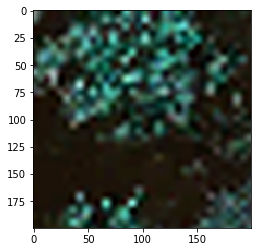

In [8]:
plt.imshow(data[1])

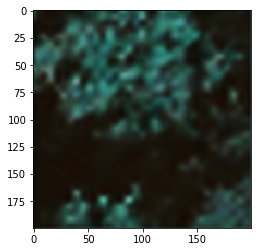

In [9]:
plt.imshow(res[1])

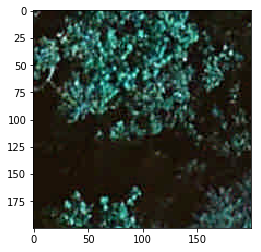

In [10]:
plt.imshow(label[1])

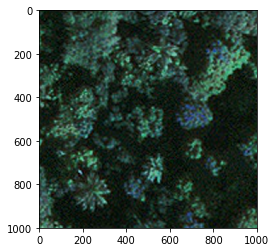

In [76]:
## load tif images
import cv2
img = cv2.imread('../images/puerto_rico_2010_0519.jpg')
img = cv2.resize(img[2000:2166, 3000:3166], (1000, 1000), interpolation = cv2.INTER_CUBIC)
imgNew = np.zeros((1, 1000, 1000, 3), dtype=np.float32)
imgNew[0] = img / 255.0
res = SRCNN.predict(imgNew)
res = (res[0] * 255).astype(np.uint8)
plt.imshow(img)